In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [6]:
from sklearn.preprocessing import StandardScaler

In [39]:
from sklearn.model_selection import KFold

In [7]:
df = pd.read_csv('course_lead_scoring.csv')

In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
target = ['converted']

In [9]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [13]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [14]:
for c in numerical:
    score = roc_auc_score(y_train, df_train[c])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[c])
    print(c, ': ', score)


number_of_courses_viewed :  0.7635680590007088
annual_income :  0.5519578313253012
interaction_count :  0.738270176293409
lead_score :  0.6144993577250176


In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical].to_dict(orient='records')
X_train_cat = dv.fit_transform(train_dict)

val_dict = df_val[categorical].to_dict(orient='records')
X_val_cat = dv.transform(val_dict)

In [19]:
scaler = StandardScaler()

X_train_num = scaler.fit_transform(df_train[numerical])
X_val_num = scaler.transform(df_val[numerical])

In [21]:
X_train = np.hstack([X_train_num, X_train_cat])
X_val = np.hstack([X_val_num, X_val_cat])

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [22]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [28]:
y_pred = model.predict_proba(X_val)[:,1]

In [29]:
roc_auc_score(y_val, y_pred>=0.5)

0.8367126833477136

In [30]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [31]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)



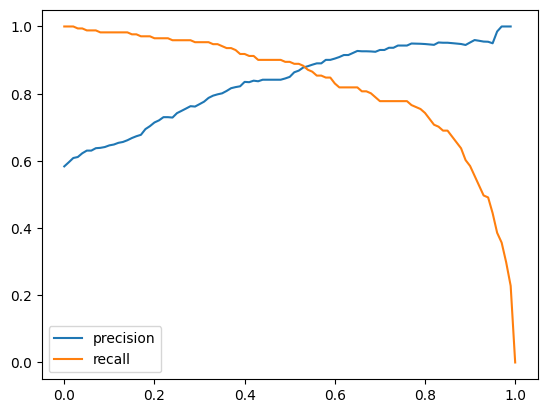

In [32]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [34]:
cross_mask = np.sign(df_scores['precision'] - df_scores['recall']).diff().ne(0)
cross_points = df_scores[cross_mask]
print(cross_points)

     threshold   tp   fp   fn   tn  precision    recall
0         0.00  171  122    0    0   0.583618  1.000000
54        0.54  149   20   22  102   0.881657  0.871345
100       1.00    0    0  171  122        NaN  0.000000


In [35]:
def cal_f1_score(precision, recall):
    f1 = 2 * precision * recall / (precision + recall)
    return f1

In [36]:
df_scores['F1_score'] = df_scores.apply(lambda row: cal_f1_score(row['precision'], row['recall']), axis=1)

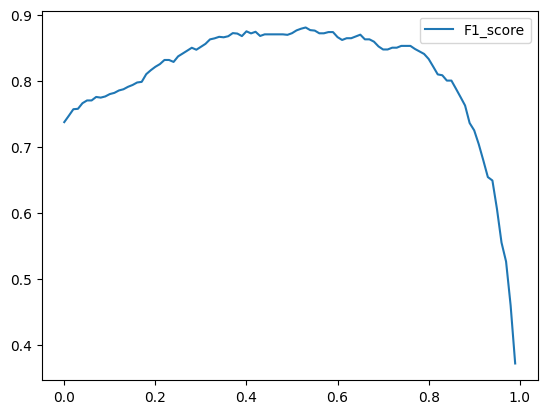

In [37]:
plt.plot(df_scores.threshold, df_scores['F1_score'], label='F1_score')
plt.legend()

In [38]:
df_scores.loc[df_scores['F1_score'].idxmax()]

threshold      0.530000
tp           151.000000
fp            21.000000
fn            20.000000
tn           101.000000
precision      0.877907
recall         0.883041
F1_score       0.880466
Name: 53, dtype: float64

## K-Fold

In [40]:
def train(df_train, y_train, C=1.0, solver='liblinear'):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver=solver, C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [41]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [42]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [43]:
from tqdm.auto import tqdm

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for C in [0.000001, 0.001, 1]:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


C=1e-06, 0.560 +- 0.024
C=0.001, 0.714 +- 0.156
C=1, 0.750 +- 0.139


In [57]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C=1
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1, 0.822 +- 0.036


In [58]:
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]